In [3]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append('/nfs/research1/zerbino/jhidalgo/inteql/inteql/')
from modelFunctions import *
from scipy.stats import ttest_ind
from scipy import stats
import random

In [4]:
from plotnine import *

# Functions

In [5]:
def random_forest_regressor_local(data, X_label, y_label, random_state, test_size=0.3, max_depth=None, n_estimators=100,
                            min_samples_split=2, min_samples_leaf=1, max_features='auto'):
    # Split data
    X = data[X_label].fillna(0)
    y = data[y_label].fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create a model and train it
    model = RandomForestRegressor(random_state=random_state, max_depth=max_depth, n_estimators=n_estimators)
    model = model.fit(X_train, y_train)

    # Predict values for test set and asses error
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
    importances = list(model.feature_importances_)
    feature_list = list(X.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    # Return result object
    return {'rmse': rmse, 'r_value': r_value, 'feature_importances': feature_importances, 'y_test':y_test, 'y_pred':y_pred,'train_index':X_train.index,'test_index':X_test.index}


In [6]:
def mean_regressor_local(data,X_label,y_label):
    X = data[X_label]
    y = data[y_label]
    y_pred = X.mean(axis=1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred)
    return {'rmse': rmse, 'r_value': r_value,'y_test':y, 'y_pred':y_pred}

In [7]:
def real_pred_plot(y_test,y_pred):
    plot=((
        ggplot(pd.DataFrame({'y_test':y_test,'y_pred':y_pred}),aes(x='y_test',y='y_pred'))+
            geom_point()+
            geom_smooth(colour='red')
    ))
    return(plot)

In [8]:
random_state = 42

# Data load and Feature definition

### eQTL Catalogue eQTL predictability test

In [9]:
# header=pd.read_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/lead_pairs/split/header.tsv',sep='\t').columns.tolist()

In [10]:
chr1=pd.read_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/monocyte-ML-input/merged_datasets.csv')

In [11]:
# chr2=pd.read_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/lead_pairs/split/chr2.tsv',sep='\t',header=None,names=header)

In [49]:
chr1['Target']=chr1[(chr1.columns[chr1.columns.str.contains('mono')]) & (chr1.columns[chr1.columns.str.contains('beta')])].mean(axis=1)

In [13]:
# chr2['Target']=chr2[(chr2.columns[chr2.columns.str.contains('mono')]) & (chr2.columns[chr2.columns.str.contains('beta')])].mean(axis=1)

In [60]:
target='Target'

In [61]:
eqtl_features=chr1.columns[chr1.columns.str.contains('beta')&(~ chr1.columns.str.contains('mono'))].tolist()

In [62]:
regbuild_features=chr1.columns[chr1.columns.str.endswith('CTCF_binding_site')].tolist()+chr1.columns[chr1.columns.str.endswith('TF_binding_site')].tolist()+chr1.columns[chr1.columns.str.endswith('_enhancer')].tolist()+chr1.columns[chr1.columns.str.endswith('_open_chromatin_region')].tolist()+chr1.columns[chr1.columns.str.endswith('_promoter')].tolist()+chr1.columns[chr1.columns.str.endswith('_promoter_flanking_region')].tolist()


In [63]:
DNAse_feature=chr1.columns[chr1.columns.str.endswith('_dnase')].tolist()

In [64]:
histone_features=chr1.columns[chr1.columns.str.contains('H3K')].tolist()

In [65]:
meth_features=chr1.columns[chr1.columns.str.contains('_M_')].tolist()

In [66]:
hic_features=chr1.columns[chr1.columns.str.startswith('HiC_')].tolist()

In [67]:
all_features=eqtl_features+regbuild_features+DNAse_feature+histone_features+meth_features+hic_features

### Data:

In [68]:
chr1.columns.tolist()

['eqtl_id',
 'Alasoo_2018.macrophage_IFNg.beta',
 'Alasoo_2018.macrophage_IFNg+Salmonella.beta',
 'Alasoo_2018.macrophage_naive.beta',
 'Alasoo_2018.macrophage_Salmonella.beta',
 'BLUEPRINT_PE.T-cell.beta',
 'BLUEPRINT_SE.monocyte.beta',
 'BLUEPRINT_SE.neutrophil.beta',
 'BrainSeq.brain.beta',
 'FUSION.adipose_naive.beta',
 'FUSION.muscle_naive.beta',
 'GENCORD.fibroblast.beta',
 'GENCORD.LCL.beta',
 'GENCORD.T-cell.beta',
 'GEUVADIS.LCL.beta',
 'GTEx.adipose_subcutaneous.beta',
 'GTEx.adipose_visceral.beta',
 'GTEx.adrenal_gland.beta',
 'GTEx.artery_aorta.beta',
 'GTEx.artery_coronary.beta',
 'GTEx.artery_tibial.beta',
 'GTEx.blood.beta',
 'GTEx.brain_amygdala.beta',
 'GTEx.brain_anterior_cingulate_cortex.beta',
 'GTEx.brain_caudate.beta',
 'GTEx.brain_cerebellar_hemisphere.beta',
 'GTEx.brain_cerebellum.beta',
 'GTEx.brain_cortex.beta',
 'GTEx.brain_frontal_cortex.beta',
 'GTEx.brain_hippocampus.beta',
 'GTEx.brain_hypothalamus.beta',
 'GTEx.brain_nucleus_accumbens.beta',
 'GTEx.brai

In [69]:
chr1[all_features]

,Alasoo_2018.macrophage_IFNg.beta,Alasoo_2018.macrophage_IFNg+Salmonella.beta,Alasoo_2018.macrophage_naive.beta,Alasoo_2018.macrophage_Salmonella.beta,BLUEPRINT_PE.T-cell.beta,BLUEPRINT_SE.neutrophil.beta,BrainSeq.brain.beta,FUSION.adipose_naive.beta,FUSION.muscle_naive.beta,GENCORD.fibroblast.beta,...,TSS_M_CpG_score,TSS_M_CpG_density,TSS_M_CHG_freq,TSS_M_CHG_score,TSS_M_CHG_density,TSS_M_CHH_freq,TSS_M_CHH_score,TSS_M_CHH_density,HiC_Contact,HiC_distance
0,0.014878,0.019929,0.007145,0.008409,-0.009101,0.012835,-0.064450,-0.124903,-0.055078,0.005894,...,66.650943,0.008131,38.194444,4.916667,0.000600,27.355140,10.112150,0.001234,0.0,99999
1,0.010908,-0.003541,0.007549,0.010561,-0.016851,0.011638,-0.059007,-0.112610,-0.064238,-0.006615,...,66.650943,0.008131,38.194444,4.916667,0.000600,27.355140,10.112150,0.001234,0.0,50000
2,0.032490,0.035531,-0.010889,0.005276,-0.024435,0.015308,-0.017674,-0.078033,-0.031212,-0.031205,...,66.650943,0.008131,38.194444,4.916667,0.000600,27.355140,10.112150,0.001234,0.0,74999
3,-0.015936,-0.023199,-0.003959,-0.011975,0.006480,0.001639,0.040951,0.102934,0.043425,0.001897,...,66.650943,0.008131,38.194444,4.916667,0.000600,27.355140,10.112150,0.001234,0.0,85001
4,0.017091,0.040628,0.002270,-0.012849,-0.046222,0.026307,-0.033465,-0.096427,-0.033965,-0.019605,...,66.650943,0.008131,38.194444,4.916667,0.000600,27.355140,10.112150,0.001234,0.0,109999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5141,NaN,NaN,NaN,NaN,NaN,NaN,0.169476,NaN,NaN,NaN,...,89.101010,0.016503,33.571429,7.742857,0.001434,26.058824,8.058824,0.001493,0.0,9999
5142,NaN,NaN,NaN,NaN,NaN,NaN,-0.481553,NaN,NaN,NaN,...,89.101010,0.016503,33.571429,7.742857,0.001434,26.058824,8.058824,0.001493,0.0,0
5143,NaN,NaN,NaN,NaN,NaN,NaN,-0.039183,NaN,NaN,-0.088815,...,53.637255,0.019177,27.526316,5.105263,0.001825,21.777778,10.688889,0.003822,0.0,25000
5144,-0.835799,-0.444700,-0.555345,-1.044910,-0.515010,-0.775167,NaN,NaN,NaN,NaN,...,91.103226,0.002071,26.704918,10.065574,0.000229,20.393103,10.813793,0.000246,0.0,0


In [70]:
chr1[(chr1.columns[chr1.columns.str.contains('mono')]) & (chr1.columns[chr1.columns.str.contains('beta')])]

,BLUEPRINT_SE.monocyte.beta,Quach_2016.monocyte_IAV.beta,Quach_2016.monocyte_LPS.beta,Quach_2016.monocyte_naive.beta,Quach_2016.monocyte_Pam3CSK4.beta,Quach_2016.monocyte_R848.beta,Schmiedel_2018.monocyte_CD16_naive.beta,Schmiedel_2018.monocyte_naive.beta
0,-0.003149,-0.020130,-0.007070,0.007386,-0.002101,0.005780,-0.008398,-0.041225
1,-0.032392,-0.020061,-0.016862,-0.020928,-0.024904,-0.021039,-0.031782,-0.071965
2,-0.002244,-0.050300,-0.035258,-0.027965,-0.027436,-0.034382,-0.049451,-0.043195
3,0.006495,-0.007284,-0.013266,-0.000248,0.017248,-0.011859,0.008887,0.012089
4,-0.001068,-0.078110,-0.054771,-0.031310,-0.034672,0.003633,-0.033983,-0.039517
...,...,...,...,...,...,...,...,...
5141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5143,NaN,0.096369,0.067853,0.032342,NaN,0.026040,NaN,-0.132259
5144,-1.162060,-2.036170,-2.048180,-1.815450,-1.918190,-1.884150,NaN,NaN


# Predictions on same chr:

## Simple mean model

### Double checking Target column creation by predicting with Mean monocyte values

In [71]:
data=chr1[chr1[target].notna()]
X_label=chr1.columns[(chr1.columns.str.contains('mono'))&(chr1.columns.str.contains('beta'))]
meanmodel=mean_regressor_local(data,X_label,target)
'rmse:',meanmodel['rmse'],'r_value:',meanmodel['r_value']

('rmse:', 0.0, 'r_value:', 1.0)

### Data = all rows where Target is not NA and at least one feature tissue is not NA

In [72]:
data=chr1[(chr1[target].notna())&(~chr1[eqtl_features].isna().all(axis=1))]
meanmodel=mean_regressor_local(data,eqtl_features,target)
'rmse:',meanmodel['rmse'],'r_value:',meanmodel['r_value']

('rmse:', 0.2875943346297959, 'r_value:', 0.6268006518683983)

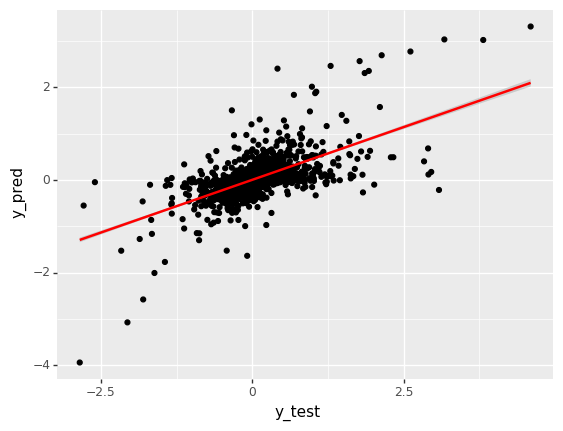

<ggplot: (2947002683245)>

In [73]:
real_pred_plot(meanmodel['y_test'],meanmodel['y_pred'])

In [104]:
mean_result=pd.DataFrame({'eqtl_id':chr1[(chr1[target].notna())&(~chr1[eqtl_features].isna().all(axis=1))]['eqtl_id'],'Real':meanmodel['y_test'],'Mean Prediction':meanmodel['y_pred']})

## eQTL RF model

In [75]:
rfmodel=random_forest_regressor_local(chr1.fillna(0), all_features, target, random_state=random_state)

In [76]:
'rmse:',rfmodel['rmse'],'r_value:',rfmodel['r_value']

('rmse:', 0.2582490305365571, 'r_value:', 0.6115706907834526)

In [77]:
rfmodel['feature_importances'][:10]

[('Nedelec_2016.macrophage_Salmonella.beta', 0.1),
 ('Nedelec_2016.macrophage_naive.beta', 0.08),
 ('GEUVADIS.LCL.beta', 0.07),
 ('BLUEPRINT_SE.neutrophil.beta', 0.06),
 ('GTEx.blood.beta', 0.05),
 ('Schmiedel_2018.CD8_T-cell_anti-CD3-CD28.beta', 0.05),
 ('GENCORD.T-cell.beta', 0.04),
 ('Nedelec_2016.macrophage_Listeria.beta', 0.04),
 ('Lepik_2017.blood.beta', 0.03),
 ('GENCORD.fibroblast.beta', 0.02)]

In [78]:
rfmodel['feature_importances'][-10:]

[('TSS_H3K4me3_score', 0.0),
 ('var_M_CpG_density', 0.0),
 ('var_M_CHG_freq', 0.0),
 ('var_M_CHG_score', 0.0),
 ('var_M_CHG_density', 0.0),
 ('var_M_CHH_freq', 0.0),
 ('var_M_CHH_score', 0.0),
 ('var_M_CHH_density', 0.0),
 ('TSS_M_CHH_density', 0.0),
 ('HiC_Contact', 0.0)]

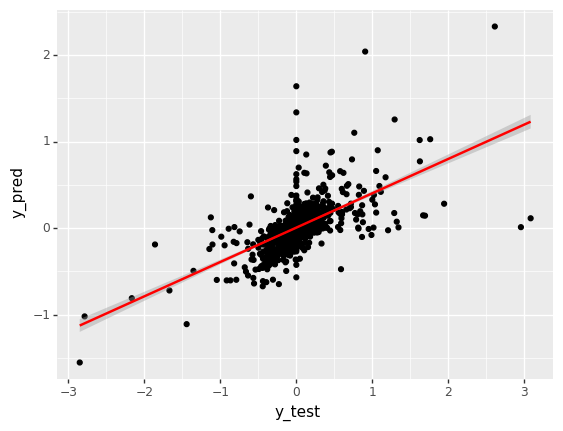

<ggplot: (2947002544207)>

In [79]:
real_pred_plot(rfmodel['y_test'],rfmodel['y_pred'])

In [107]:
rf_result=pd.DataFrame({'eqtl_id':chr1.loc[rfmodel['test_index']]['eqtl_id'],'Real':chr1.loc[rfmodel['test_index']]['Target'],'RF Prediction':rfmodel['y_pred']})

In [111]:
mean_result.merge(rf_result,how='outer').to_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/mean_rf_output.csv',index=False)

In [44]:
# Only pairs with HiC data

In [47]:
rfmodel=random_forest_regressor_local(chr1[chr1['HiC_Contact'].fillna(0)!=0].fillna(0), all_features, target, random_state=random_state)

In [48]:
'rmse:',rfmodel['rmse'],'r_value:',rfmodel['r_value']

('rmse:', 0.34612638373201526, 'r_value:', 0.4560716546365388)

In [50]:
len(chr1[chr1['HiC_Contact'].fillna(0)!=0].fillna(0)), len(chr1)

(585, 5146)

# Each Dataset RF model

#### DNAse

In [195]:
feature=DNAse_feature

In [196]:
feature_rfmodel=random_forest_regressor_local(chr1.fillna(0), feature, target, random_state=random_state)

In [197]:
'rmse:',feature_rfmodel['rmse'],'r_value:',feature_rfmodel['r_value']

('rmse:', 0.3304413837710226, 'r_value:', 0.029795627600085216)

In [198]:
feature_rfmodel['feature_importances'][:10]

[('DNAse-seq', 1.0)]

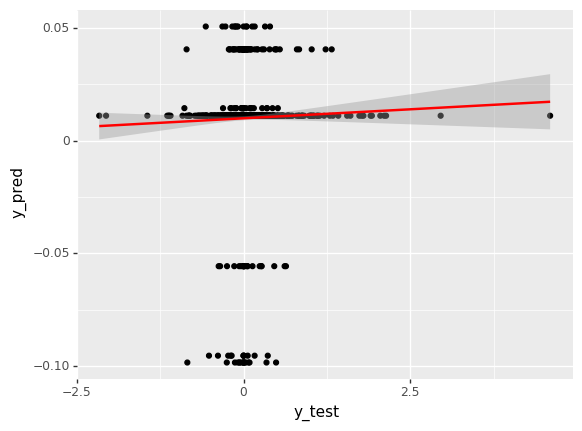

<ggplot: (2950822905941)>

In [199]:
real_pred_plot(feature_rfmodel['y_test'],feature_rfmodel['y_pred'])

#### RegBuild

In [200]:
feature=regbuild_features

In [201]:
feature_rfmodel=random_forest_regressor_local(chr1.fillna(0), feature, target, random_state=random_state)

In [202]:
'rmse:',feature_rfmodel['rmse'],'r_value:',feature_rfmodel['r_value']

('rmse:', 0.33215410320943095, 'r_value:', 0.019033357977875306)

In [203]:
feature_rfmodel['feature_importances'][:10]

[('RegBuild_promoter', 0.45),
 ('RegBuild_CTCF_binding_site', 0.26),
 ('RegBuild_open_chromatin_region', 0.14),
 ('RegBuild_promoter_flanking_region', 0.07),
 ('RegBuild_TF_binding_site', 0.04),
 ('RegBuild_enhancer', 0.03)]

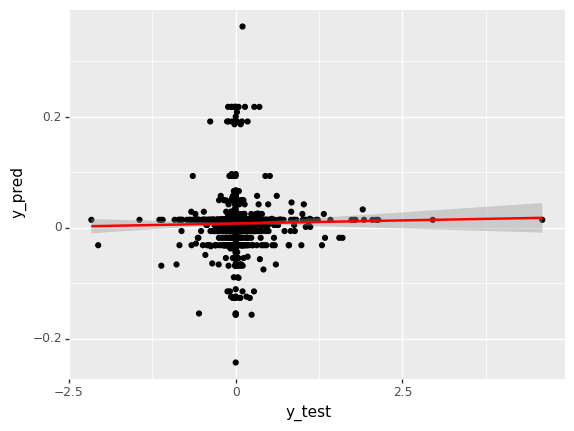

<ggplot: (2950822960589)>

In [204]:
real_pred_plot(feature_rfmodel['y_test'],feature_rfmodel['y_pred'])

#### Histone

In [205]:
feature=histone_features

In [206]:
feature_rfmodel=random_forest_regressor_local(chr1.fillna(0), feature, target, random_state=random_state)

In [207]:
'rmse:',feature_rfmodel['rmse'],'r_value:',feature_rfmodel['r_value']

('rmse:', 0.33711201713664396, 'r_value:', 0.04624504140817392)

In [208]:
feature_rfmodel['feature_importances'][:10]

[('H3K27ac_score', 0.46),
 ('H3K4me3_score', 0.43),
 ('H3K4me3_freq', 0.06),
 ('H3K27ac_freq', 0.05)]

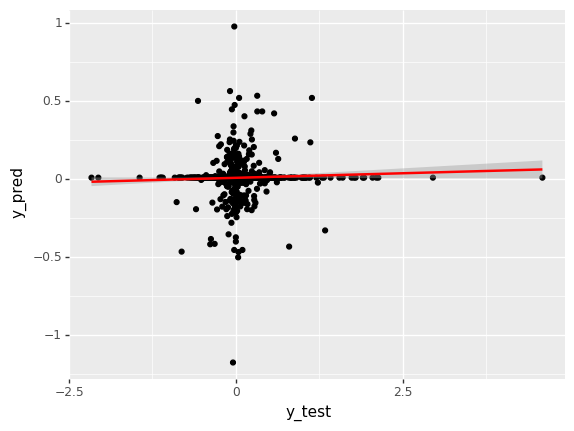

<ggplot: (2950822992875)>

In [209]:
real_pred_plot(feature_rfmodel['y_test'],feature_rfmodel['y_pred'])

#### Methylation

In [210]:
feature=meth_features

In [211]:
feature_rfmodel=random_forest_regressor_local(chr1.fillna(0), feature, target, random_state=random_state)

In [212]:
'rmse:',feature_rfmodel['rmse'],'r_value:',feature_rfmodel['r_value']

('rmse:', 0.3415943703908989, 'r_value:', -0.03130631383440181)

In [213]:
feature_rfmodel['feature_importances'][:10]

[('M_CpG_Freq', 0.39),
 ('M_CpG_Score', 0.27),
 ('M_CHG_Freq', 0.13),
 ('M_CHG_Score', 0.13),
 ('M_CHH_Freq', 0.04),
 ('M_CHH_Score', 0.04)]

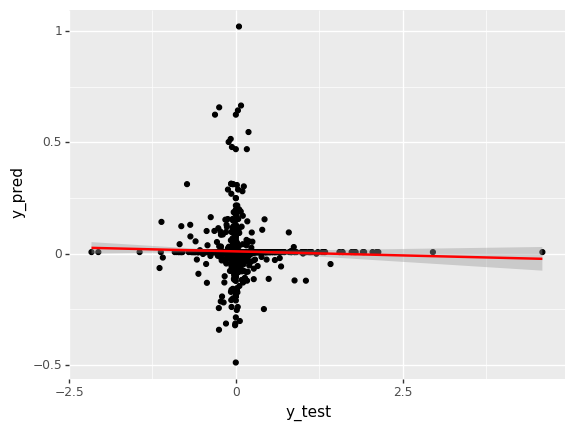

<ggplot: (2950822889247)>

In [214]:
real_pred_plot(feature_rfmodel['y_test'],feature_rfmodel['y_pred'])

#### Histone

In [205]:
feature=eqtl

In [206]:
feature_rfmodel=random_forest_regressor_local(chr1.fillna(0), feature, target, random_state=random_state)

In [207]:
'rmse:',feature_rfmodel['rmse'],'r_value:',feature_rfmodel['r_value']

('rmse:', 0.33711201713664396, 'r_value:', 0.04624504140817392)

In [208]:
feature_rfmodel['feature_importances'][:10]

[('H3K27ac_score', 0.46),
 ('H3K4me3_score', 0.43),
 ('H3K4me3_freq', 0.06),
 ('H3K27ac_freq', 0.05)]

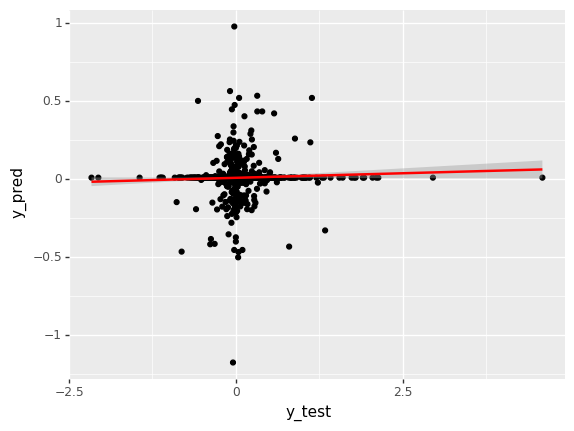

<ggplot: (2950822992875)>

In [209]:
real_pred_plot(feature_rfmodel['y_test'],feature_rfmodel['y_pred'])

# OLD

In [22]:
ML_data=pd.read_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/ML_input.csv')

In [23]:
ML_data

,contig,start,end,gene_id,eQTL,var_chr,var_pos,Adipose_Subcutaneous_z,Adipose_Visceral_Omentum_z,Adrenal_Gland_z,...,TF binding site_gene,CTCF Binding Site_var,Enhancer_var,Open chromatin_var,Promoter_var,Promoter Flanking Region_var,TF binding site_var,Same_loop,distance,indel_len
0,3,49689499,49721529,ENSG00000164068,chr3_49707457,3,49707457,0.128300,0.005427,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17958,0.0
1,2,44361950,44772592,ENSG00000143919,chr2_44452146,2,44452146,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-90196,0.0
2,17,46193576,46196723,ENSG00000214401,chr17_46275267,17,46275267,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81691,1.0
3,11,69641087,69654474,ENSG00000110092,chr11_69246550,11,69246550,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,394537,0.0
4,10,79682997,79685436,ENSG00000278616,chr10_79700217,10,79700217,NaN,NaN,0.003335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17220,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,19,6729914,6737603,ENSG00000125734,chr19_6722011,19,6722011,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7903,NaN
1704,2,74458329,74460891,ENSG00000239779,chr2_74518802,2,74518802,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-60473,0.0
1705,11,61430042,61447529,ENSG00000167985,chr11_61256534,11,61256534,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173508,0.0
1706,17,37977972,37989048,ENSG00000274512,chr17_38261195,17,38261195,0.999776,0.123429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-283223,0.0


### eQTL features = columns from Adipose_Subcutaneous to Whole_Blood

In [24]:
eQTL_features_z=ML_data.columns[ML_data.columns.str.contains('_z')].to_list()

In [25]:
eQTL_features_slope=ML_data.columns[ML_data.columns.str.contains('_slope')].to_list()

### Positional features such as chromosome and gene and variant positions

In [26]:
pos_features=['var_chr','var_pos', 'start', 'end','distance']

In [27]:
var_features=['Ref','Alt','indel_len']

### Regulatory Build features

In [28]:
regbuild_features=ML_data.columns[ML_data.columns.str.contains('_var') | ML_data.columns.str.contains('_gene')].to_list()

In [29]:
# Alternative Regulatory Build feature only for variant intersection data
var_features_alt=ML_data.columns[ML_data.columns.str.contains('_var_')].to_list()

In [30]:
# Alternative Regulatory Build feature only for gene intersection data
gene_features_alt=ML_data.columns[ML_data.columns.str.contains('_gene_')].to_list()

### HiC

In [31]:
hic_features=['Same_loop']

## Features and target

In [32]:
features=eQTL_features_z+eQTL_features_slope+pos_features+regbuild_features+hic_features+var_features

In [33]:
target='Cells_EBV-transformed_lymphocytes'

In [34]:
ML_data[features].columns.to_list()

['Adipose_Subcutaneous_z',
 'Adipose_Visceral_Omentum_z',
 'Adrenal_Gland_z',
 'Artery_Aorta_z',
 'Artery_Coronary_z',
 'Artery_Tibial_z',
 'Brain_Amygdala_z',
 'Brain_Anterior_cingulate_cortex_BA24_z',
 'Brain_Caudate_basal_ganglia_z',
 'Brain_Cerebellar_Hemisphere_z',
 'Brain_Cerebellum_z',
 'Brain_Cortex_z',
 'Brain_Frontal_Cortex_BA9_z',
 'Brain_Hippocampus_z',
 'Brain_Hypothalamus_z',
 'Brain_Nucleus_accumbens_basal_ganglia_z',
 'Brain_Putamen_basal_ganglia_z',
 'Brain_Spinal_cord_cervical_c-1_z',
 'Brain_Substantia_nigra_z',
 'Breast_Mammary_Tissue_z',
 'Cells_Cultured_fibroblasts_z',
 'Colon_Sigmoid_z',
 'Colon_Transverse_z',
 'Esophagus_Gastroesophageal_Junction_z',
 'Esophagus_Mucosa_z',
 'Esophagus_Muscularis_z',
 'Heart_Atrial_Appendage_z',
 'Heart_Left_Ventricle_z',
 'Kidney_Cortex_z',
 'Liver_z',
 'Lung_z',
 'Minor_Salivary_Gland_z',
 'Muscle_Skeletal_z',
 'Nerve_Tibial_z',
 'Ovary_z',
 'Pancreas_z',
 'Pituitary_z',
 'Prostate_z',
 'Skin_Not_Sun_Exposed_Suprapubic_z',
 'Sk

# Models

### Mean eQTL regression model

In [35]:
mean_regressor_local(ML_data[ML_data[eQTL_features_z].notna().any(axis=1)],eQTL_features_z,target)

{'rmse': 0.27877456228757774, 'r_value': 0.7501534137277371}

### Model using all features

In [37]:
random_forest_regressor_local(ML_data.fillna(0), features, target, random_state=random_state)

{'rmse': 0.2141044029943621,
 'r_value': 0.7902408660173841,
 'feature_importances': [('Same_loop', 0.35),
  ('distance', 0.17),
  ('Esophagus_Mucosa_z', 0.04),
  ('var_chr', 0.04),
  ('var_pos', 0.03),
  ('start', 0.03),
  ('end', 0.03),
  ('Adipose_Visceral_Omentum_z', 0.01),
  ('Artery_Tibial_z', 0.01),
  ('Cells_Cultured_fibroblasts_z', 0.01),
  ('Colon_Transverse_z', 0.01),
  ('Esophagus_Muscularis_z', 0.01),
  ('Lung_z', 0.01),
  ('Small_Intestine_Terminal_Ileum_z', 0.01),
  ('Spleen_z', 0.01),
  ('Testis_z', 0.01),
  ('Thyroid_z', 0.01),
  ('Whole_Blood_z', 0.01),
  ('Cells_Cultured_fibroblasts_slope', 0.01),
  ('Esophagus_Mucosa_slope', 0.01),
  ('Skin_Sun_Exposed_Lower_leg_slope', 0.01),
  ('Testis_slope', 0.01),
  ('Whole_Blood_slope', 0.01),
  ('Ref', 0.01),
  ('Alt', 0.01),
  ('Adipose_Subcutaneous_z', 0.0),
  ('Adrenal_Gland_z', 0.0),
  ('Artery_Aorta_z', 0.0),
  ('Artery_Coronary_z', 0.0),
  ('Brain_Amygdala_z', 0.0),
  ('Brain_Anterior_cingulate_cortex_BA24_z', 0.0),
  (

### Model using eQTL features

In [148]:
random_forest_regressor_local(ML_data.fillna(0), eQTL_features_z, target, random_state=random_state)

{'rmse': 0.23974335314697584,
 'r_value': 0.7272155781726386,
 'feature_importances': [('Esophagus_Mucosa_z', 0.18),
  ('Cells_Cultured_fibroblasts_z', 0.13),
  ('Spleen_z', 0.06),
  ('Nerve_Tibial_z', 0.04),
  ('Thyroid_z', 0.04),
  ('Whole_Blood_z', 0.04),
  ('Colon_Transverse_z', 0.03),
  ('Esophagus_Muscularis_z', 0.03),
  ('Lung_z', 0.03),
  ('Testis_z', 0.03),
  ('Adipose_Subcutaneous_z', 0.02),
  ('Adipose_Visceral_Omentum_z', 0.02),
  ('Artery_Aorta_z', 0.02),
  ('Brain_Cerebellum_z', 0.02),
  ('Breast_Mammary_Tissue_z', 0.02),
  ('Heart_Atrial_Appendage_z', 0.02),
  ('Small_Intestine_Terminal_Ileum_z', 0.02),
  ('Stomach_z', 0.02),
  ('Adrenal_Gland_z', 0.01),
  ('Artery_Coronary_z', 0.01),
  ('Artery_Tibial_z', 0.01),
  ('Brain_Caudate_basal_ganglia_z', 0.01),
  ('Brain_Cerebellar_Hemisphere_z', 0.01),
  ('Brain_Cortex_z', 0.01),
  ('Brain_Frontal_Cortex_BA9_z', 0.01),
  ('Brain_Hippocampus_z', 0.01),
  ('Brain_Hypothalamus_z', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia

### Top feature selection and model

In [155]:
topfeatures=[]
rmse_top=1
i=0
discarded=[]
random_forest_all=random_forest_regressor_local(ML_data.fillna(0), features, target, random_state=random_state)
while i < len(random_forest_all['feature_importances']):
    print('Testing',random_forest_all['feature_importances'][i][0],end=': ')
    test=random_forest_regressor_local(ML_data.fillna(0), topfeatures+[random_forest_all['feature_importances'][i][0]], target, random_state=random_state)
    if test['rmse'] < rmse_top:
        topfeatures=topfeatures+[random_forest_all['feature_importances'][i][0]]
        rmse_top=test['rmse']
        print('\t','Added.')
    else:
        print('\t','Discarded.')
        discarded.append(i)
    i=i+1

a=0
while a < len(discarded):
    i=discarded[a]
    print('Re-Testing',random_forest_all['feature_importances'][i][0],end=': ')
    test=random_forest_regressor_local(ML_data.fillna(0), topfeatures+[random_forest_all['feature_importances'][i][0]], target, random_state=random_state)
    if test['rmse'] < rmse_top:
        topfeatures=topfeatures+[random_forest_all['feature_importances'][i][0]]
        rmse_top=test['rmse']
        print('\t','Added.')
    else:
        print('\t','Discarded again.')
    a=a+1

Testing Same_loop: 	 Added.
Testing distance: 	 Discarded.
Testing Esophagus_Mucosa_z: 	 Added.
Testing var_chr: 	 Added.
Testing var_pos: 	 Added.
Testing start: 	 Added.
Testing end: 	 Discarded.
Testing Adipose_Visceral_Omentum_z: 	 Added.
Testing Artery_Tibial_z: 	 Added.
Testing Cells_Cultured_fibroblasts_z: 	 Added.
Testing Colon_Transverse_z: 	 Added.
Testing Esophagus_Muscularis_z: 	 Added.
Testing Lung_z: 	 Added.
Testing Small_Intestine_Terminal_Ileum_z: 	 Added.
Testing Spleen_z: 	 Discarded.
Testing Testis_z: 	 Added.
Testing Thyroid_z: 	 Added.
Testing Whole_Blood_z: 	 Discarded.
Testing Cells_Cultured_fibroblasts_slope: 	 Added.
Testing Esophagus_Mucosa_slope: 	 Discarded.
Testing Skin_Sun_Exposed_Lower_leg_slope: 	 Added.
Testing Testis_slope: 	 Discarded.
Testing Whole_Blood_slope: 	 Added.
Testing Ref: 	 Discarded.
Testing Alt: 	 Discarded.
Testing Adipose_Subcutaneous_z: 	 Discarded.
Testing Adrenal_Gland_z: 	 Added.
Testing Artery_Aorta_z: 	 Discarded.
Testing Artery

In [158]:
random_forest_regressor_local(ML_data.fillna(0), topfeatures, target, random_state=random_state)

{'rmse': 0.20677517707268053,
 'r_value': 0.8055467723344617,
 'feature_importances': [('Same_loop', 0.35),
  ('var_pos', 0.09),
  ('start', 0.08),
  ('var_chr', 0.06),
  ('Esophagus_Mucosa_z', 0.04),
  ('Colon_Transverse_z', 0.04),
  ('Whole_Blood_slope', 0.03),
  ('Cells_Cultured_fibroblasts_z', 0.02),
  ('Esophagus_Muscularis_z', 0.02),
  ('Lung_z', 0.02),
  ('Testis_z', 0.02),
  ('Thyroid_z', 0.02),
  ('Cells_Cultured_fibroblasts_slope', 0.02),
  ('Skin_Sun_Exposed_Lower_leg_slope', 0.02),
  ('Adipose_Visceral_Omentum_z', 0.01),
  ('Artery_Tibial_z', 0.01),
  ('Small_Intestine_Terminal_Ileum_z', 0.01),
  ('Brain_Frontal_Cortex_BA9_z', 0.01),
  ('Brain_Hippocampus_z', 0.01),
  ('Colon_Sigmoid_z', 0.01),
  ('Heart_Atrial_Appendage_z', 0.01),
  ('Liver_z', 0.01),
  ('Muscle_Skeletal_z', 0.01),
  ('Pituitary_z', 0.01),
  ('Adipose_Subcutaneous_slope', 0.01),
  ('Adipose_Visceral_Omentum_slope', 0.01),
  ('Artery_Aorta_slope', 0.01),
  ('Brain_Cerebellum_slope', 0.01),
  ('Brain_Frontal

In [159]:
random_forest_regressor_local(ML_data.fillna(0), regbuild_features, target, random_state=random_state)

{'rmse': 0.3237930147717386,
 'r_value': 0.37450930534127064,
 'feature_importances': [('Promoter_gene', 0.84),
  ('Promoter Flanking Region_gene', 0.04),
  ('Promoter_var', 0.03),
  ('CTCF Binding Site_gene', 0.02),
  ('Open chromatin_gene', 0.02),
  ('TF binding site_gene', 0.02),
  ('Enhancer_gene', 0.01),
  ('Promoter Flanking Region_var', 0.01),
  ('CTCF Binding Site_var', 0.0),
  ('Enhancer_var', 0.0),
  ('Open chromatin_var', 0.0),
  ('TF binding site_var', 0.0)],
 'y_test': 567     0.270492
 1325    0.913926
 1350    0.988934
 115     0.000931
 453     0.337800
           ...   
 1661    0.956894
 864     0.669369
 1058    0.615410
 1664    0.897217
 327     0.099290
 Name: Cells_EBV-transformed_lymphocytes, Length: 513, dtype: float64,
 'y_pred': array([0.46312221, 0.46312221, 0.46312221, 0.46312221, 0.46312221,
        0.46312221, 0.46312221, 0.46312221, 0.46312221, 0.46312221,
        0.46312221, 0.46312221, 0.46312221, 0.88506291, 0.80478529,
        0.46312221, 0.46312221,

In [120]:
random_forest_regressor_local(ML_data.fillna(0), pos_features, target, random_state=random_state)

{'rmse': 0.31106110898024936,
 'r_value': 0.49560494890856455,
 'feature_importances': [('var_pos', 0.35),
  ('start', 0.25),
  ('end', 0.24),
  ('var_chr', 0.17)],
 'y_test': 1429    0.787100
 231     0.180012
 2019    0.846300
 297     0.027810
 2053    0.960870
           ...   
 1433    0.765030
 727     0.435835
 187     0.011890
 619     0.203921
 1847    0.869287
 Name: Cells_EBV-transformed_lymphocytes, Length: 641, dtype: float64,
 'y_pred': array([0.86374327, 0.45314342, 0.71114084, 0.63265207, 0.85369316,
        0.46517406, 0.93703577, 0.36715751, 0.54293833, 0.76140047,
        0.93058762, 0.25365306, 0.34546074, 0.84603286, 0.48974127,
        0.75791263, 0.76859827, 0.17673413, 0.91254777, 0.76925406,
        0.81288268, 0.34001654, 0.72945036, 0.4848414 , 0.19928519,
        0.11108927, 0.82635296, 0.13374138, 0.74336211, 0.80411667,
        0.43203523, 0.83294692, 0.42348731, 0.58077392, 0.81473789,
        0.64061475, 0.38421793, 0.36619842, 0.78451864, 0.62132498,
  

# Old results

In [197]:
random_forest_all = random_forest_regressor_local(ML_data.fillna(0), features, target, random_state=random_state)

In [128]:
### PREVIOUS RUN WITH CAVIAR AND CAVEMAN ONLY

{'rmse': 0.12363173650806675,
 'r_value': 0.7162966516379248,
 'feature_importances': [('Colon_Transverse', 0.16),
  ('Spleen', 0.07),
  ('Cells_Cultured_fibroblasts', 0.06),
  ('Esophagus_Mucosa', 0.04),
  ('Whole_Blood', 0.04),
  ('Small_Intestine_Terminal_Ileum', 0.03),
  ('contig', 0.03),
  ('Esophagus_Gastroesophageal_Junction', 0.02),
  ('Lung', 0.02),
  ('Skin_Not_Sun_Exposed_Suprapubic', 0.02),
  ('Skin_Sun_Exposed_Lower_leg', 0.02),
  ('POS', 0.02),
  ('start', 0.02),
  ('end', 0.02),
  ('Adipose_Subcutaneous', 0.01),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Adrenal_Gland', 0.01),
  ('Artery_Aorta', 0.01),
  ('Artery_Coronary', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Amygdala', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Putamen_basal_ganglia', 0.01),
  ('Brain_Sp

In [65]:
### PREVIOUS RUN WITH WHOLE DATASET
random_forest_all

{'rmse': 0.08031761008912681,
 'r_value': 0.7577702243467606,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.15),
  ('Esophagus_Mucosa', 0.07),
  ('Lung', 0.07),
  ('Spleen', 0.07),
  ('Whole_Blood', 0.06),
  ('Small_Intestine_Terminal_Ileum', 0.03),
  ('Adipose_Subcutaneous', 0.02),
  ('Colon_Transverse', 0.02),
  ('var_pos', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Adrenal_Gland', 0.01),
  ('Artery_Aorta', 0.01),
  ('Artery_Coronary', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.01),
  ('Brain_Putamen_basal_ganglia', 0.01),
  ('Brain_Spinal_cord_cervical_c-1', 0.01),
  ('Breast_Mammary_Tissue', 0.01),
  ('Colon_Sigmoid', 0.01),
  ('Esophagus_Gastroesophageal_Junction', 0.01),
  ('Esophagus_Muscul

In [198]:
random_forest_all

{'rmse': 0.18600508975953886,
 'r_value': 0.8397175888790808,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.19),
  ('Spleen', 0.1),
  ('Whole_Blood', 0.09),
  ('Thyroid', 0.05),
  ('Lung', 0.04),
  ('Nerve_Tibial', 0.03),
  ('Small_Intestine_Terminal_Ileum', 0.03),
  ('Adipose_Visceral_Omentum', 0.02),
  ('Artery_Aorta', 0.02),
  ('Breast_Mammary_Tissue', 0.02),
  ('Esophagus_Gastroesophageal_Junction', 0.02),
  ('Esophagus_Mucosa', 0.02),
  ('Skin_Not_Sun_Exposed', 0.02),
  ('var_pos', 0.02),
  ('start', 0.02),
  ('gene_Promoter Flanking Region', 0.02),
  ('Adipose_Subcutaneous', 0.01),
  ('Adrenal_Gland', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Putamen_basal_ganglia', 0.01),
  ('Colon_Sigmoid', 0.01),
  ('Colon_Transverse', 0.01),
  ('Esophagus_Muscularis', 0.01),
  ('Heart_Atrial_Appendage', 0.01),

In [199]:
random_forest_eQTL = random_forest_regressor_local(ML_data.fillna(0), eQTL_features, target, random_state=random_state)

In [130]:
### PREVIOUS RUN WITH CAVEMAN AND CAVIAR

{'rmse': 0.12813530636027837,
 'r_value': 0.6915418031688241,
 'feature_importances': [('Colon_Transverse', 0.17),
  ('Spleen', 0.08),
  ('Cells_Cultured_fibroblasts', 0.07),
  ('Whole_Blood', 0.05),
  ('Esophagus_Mucosa', 0.04),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('Adipose_Subcutaneous', 0.02),
  ('Brain_Caudate_basal_ganglia', 0.02),
  ('Brain_Hypothalamus', 0.02),
  ('Breast_Mammary_Tissue', 0.02),
  ('Esophagus_Gastroesophageal_Junction', 0.02),
  ('Heart_Atrial_Appendage', 0.02),
  ('Lung', 0.02),
  ('Muscle_Skeletal', 0.02),
  ('Nerve_Tibial', 0.02),
  ('Prostate', 0.02),
  ('Skin_Not_Sun_Exposed_Suprapubic', 0.02),
  ('Skin_Sun_Exposed_Lower_leg', 0.02),
  ('Testis', 0.02),
  ('Thyroid', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Adrenal_Gland', 0.01),
  ('Artery_Aorta', 0.01),
  ('Artery_Coronary', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Amygdala', 0.01),
  ('Brain_Anterior_cingulate_cortex_BA24', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Ce

In [67]:
### PREVIOUS RUN WITH WHOLE DATASET
random_forest_eQTL

{'rmse': 0.08296696089429297,
 'r_value': 0.7386141491737227,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.16),
  ('Esophagus_Mucosa', 0.08),
  ('Lung', 0.07),
  ('Spleen', 0.07),
  ('Whole_Blood', 0.07),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('Adipose_Subcutaneous', 0.03),
  ('Adrenal_Gland', 0.02),
  ('Artery_Aorta', 0.02),
  ('Artery_Tibial', 0.02),
  ('Colon_Transverse', 0.02),
  ('Esophagus_Muscularis', 0.02),
  ('Nerve_Tibial', 0.02),
  ('Skin_Sun_Exposed', 0.02),
  ('Stomach', 0.02),
  ('Testis', 0.02),
  ('Thyroid', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Artery_Coronary', 0.01),
  ('Brain_Anterior_cingulate_cortex_BA24', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.01),
  ('Brain_Putamen_basal_ganglia', 0

In [200]:
random_forest_eQTL

{'rmse': 0.19634446278645215,
 'r_value': 0.8178151433188015,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.2),
  ('Whole_Blood', 0.11),
  ('Spleen', 0.1),
  ('Thyroid', 0.05),
  ('Lung', 0.04),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('Nerve_Tibial', 0.03),
  ('Adipose_Subcutaneous', 0.02),
  ('Adipose_Visceral_Omentum', 0.02),
  ('Artery_Aorta', 0.02),
  ('Breast_Mammary_Tissue', 0.02),
  ('Esophagus_Gastroesophageal_Junction', 0.02),
  ('Esophagus_Mucosa', 0.02),
  ('Skin_Not_Sun_Exposed', 0.02),
  ('Stomach', 0.02),
  ('Testis', 0.02),
  ('Adrenal_Gland', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellar_Hemisphere', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.01),
  ('Brain_Putamen_basal_ganglia', 0.01),
  ('Brain_Spinal_cord_cervical_c-1', 0.01),
  ('Col

In [201]:
mean_eQTL = mean_regressor_local(ML_data,eQTL_features,target)

In [132]:
### PREVIOUS MEAN RUN

{'rmse': 0.1562592667922336, 'r_value': 0.6366415884930854}

In [69]:
### PREVIOUS MEAN RUN
mean_eQTL

{'rmse': 0.09242904185468812, 'r_value': 0.7121875585046714}

In [202]:
mean_eQTL

{'rmse': 0.29029019486085833, 'r_value': 0.7254916871134982}

In [203]:
topfeatures=[]
rmse_top=1
i=0
while i < len(random_forest_all['feature_importances']):
    print('Testing',random_forest_all['feature_importances'][i][0],end=': ')
    test=random_forest_regressor_local(ML_data.fillna(0), topfeatures+[random_forest_all['feature_importances'][i][0]], target, random_state=random_state)
    if test['rmse'] < rmse_top:
        topfeatures=topfeatures+[random_forest_all['feature_importances'][i][0]]
        rmse_top=test['rmse']
        print('\t','Added.')
    else:
        print('\t','Discarded.')

    i=i+1

Testing Cells_Cultured_fibroblasts: 	 Added.
Testing Spleen: 	 Added.
Testing Whole_Blood: 	 Added.
Testing Thyroid: 	 Added.
Testing Lung: 	 Added.
Testing Nerve_Tibial: 	 Added.
Testing Small_Intestine_Terminal_Ileum: 	 Added.
Testing Adipose_Visceral_Omentum: 	 Added.
Testing Artery_Aorta: 	 Added.
Testing Breast_Mammary_Tissue: 	 Added.
Testing Esophagus_Gastroesophageal_Junction: 	 Added.
Testing Esophagus_Mucosa: 	 Added.
Testing Skin_Not_Sun_Exposed: 	 Added.
Testing var_pos: 	 Added.
Testing start: 	 Added.
Testing gene_Promoter Flanking Region: 	 Added.
Testing Adipose_Subcutaneous: 	 Added.
Testing Adrenal_Gland: 	 Discarded.
Testing Artery_Tibial: 	 Added.
Testing Brain_Cerebellar_Hemisphere: 	 Discarded.
Testing Brain_Cerebellum: 	 Added.
Testing Brain_Frontal_Cortex_BA9: 	 Discarded.
Testing Brain_Hippocampus: 	 Discarded.
Testing Brain_Hypothalamus: 	 Discarded.
Testing Brain_Putamen_basal_ganglia: 	 Discarded.
Testing Colon_Sigmoid: 	 Added.
Testing Colon_Transverse: 	 D

In [166]:
### PREVIOUS TOP FEATURES RESULT

{'rmse': 0.12173501200193489,
 'r_value': 0.7266298227963061,
 'feature_importances': [('Colon_Transverse', 0.17),
  ('Spleen', 0.08),
  ('Cells_Cultured_fibroblasts', 0.07),
  ('Esophagus_Mucosa', 0.05),
  ('POS', 0.05),
  ('Whole_Blood', 0.04),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('contig', 0.04),
  ('start', 0.04),
  ('Esophagus_Gastroesophageal_Junction', 0.03),
  ('Skin_Sun_Exposed_Lower_leg', 0.03),
  ('Lung', 0.02),
  ('Adrenal_Gland', 0.02),
  ('Artery_Tibial', 0.02),
  ('Brain_Caudate_basal_ganglia', 0.02),
  ('Brain_Hypothalamus', 0.02),
  ('Breast_Mammary_Tissue', 0.02),
  ('Heart_Left_Ventricle', 0.02),
  ('Minor_Salivary_Gland', 0.02),
  ('Ovary', 0.02),
  ('Prostate', 0.02),
  ('Stomach', 0.02),
  ('Testis', 0.02),
  ('Thyroid', 0.02),
  ('gene_CTCF Binding Site', 0.02),
  ('gene_Promoter Flanking Region', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Substantia_nigra', 0.01),
  ('Uterus', 0.01),
  ('var_Promoter', 0.01),


In [244]:
random_forest_regressor_local(ML_data.fillna(0), regbuild_features, target, random_state=random_state)

{'rmse': 0.3090903138195705,
 'r_value': 0.43088276749107784,
 'feature_importances': [('gene_Promoter Flanking Region', 0.17),
  ('gene_CTCF Binding Site', 0.15),
  ('gene_TF binding site', 0.14),
  ('gene_Enhancer', 0.12),
  ('var_Promoter', 0.11),
  ('gene_Open chromatin', 0.11),
  ('gene_Promoter', 0.1),
  ('var_Promoter Flanking Region', 0.04),
  ('var_CTCF Binding Site', 0.02),
  ('var_Open chromatin', 0.02),
  ('var_Enhancer', 0.01),
  ('var_TF binding site', 0.01)],
 'y_test': 940     0.442700
 986     0.417560
 405     0.210704
 721     0.736935
 1610    0.887031
           ...   
 1620    0.984255
 679     0.420631
 1421    0.894592
 900     0.454629
 221     0.110509
 Name: Cells_EBV-transformed_lymphocytes, Length: 500, dtype: float64,
 'y_pred': array([0.86335132, 0.53775163, 0.3151104 , 0.51305009, 0.37034786,
        0.49241344, 0.81629965, 0.59168177, 0.59168177, 0.21777909,
        0.38574185, 0.59168177, 0.52419497, 0.59161205, 0.84428256,
        0.24542164, 0.649372

In [204]:
topmodel=random_forest_regressor_local(ML_data.fillna(0), topfeatures, target, random_state=random_state)

In [185]:
#Previous
topmodel

{'rmse': 0.0799029760625044,
 'r_value': 0.7607506457636488,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.15),
  ('Esophagus_Mucosa', 0.08),
  ('Lung', 0.07),
  ('Spleen', 0.07),
  ('Whole_Blood', 0.06),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('Adipose_Subcutaneous', 0.03),
  ('var_pos', 0.03),
  ('Colon_Transverse', 0.02),
  ('Adipose_Visceral_Omentum', 0.02),
  ('Adrenal_Gland', 0.02),
  ('Artery_Aorta', 0.02),
  ('Muscle_Skeletal', 0.02),
  ('Skin_Sun_Exposed', 0.02),
  ('Stomach', 0.02),
  ('Testis', 0.02),
  ('contig', 0.02),
  ('var_chr', 0.02),
  ('start', 0.02),
  ('end', 0.02),
  ('Artery_Coronary', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hippocampus', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.01),
  ('Brain_Putamen_basal_ganglia', 0.01),
  ('Brain_Spinal_cord_cervical_c-1', 0.01),
  ('Heart_Atrial_Append

In [205]:
topmodel

{'rmse': 0.1821277880068773,
 'r_value': 0.8471472364805396,
 'feature_importances': [('Cells_Cultured_fibroblasts', 0.2),
  ('Spleen', 0.11),
  ('Whole_Blood', 0.1),
  ('Thyroid', 0.05),
  ('Lung', 0.04),
  ('Small_Intestine_Terminal_Ileum', 0.04),
  ('var_pos', 0.04),
  ('start', 0.04),
  ('Nerve_Tibial', 0.03),
  ('Breast_Mammary_Tissue', 0.03),
  ('Esophagus_Gastroesophageal_Junction', 0.03),
  ('Esophagus_Mucosa', 0.03),
  ('Adipose_Visceral_Omentum', 0.02),
  ('Artery_Aorta', 0.02),
  ('Skin_Not_Sun_Exposed', 0.02),
  ('gene_Promoter Flanking Region', 0.02),
  ('Adipose_Subcutaneous', 0.02),
  ('gene_CTCF Binding Site', 0.02),
  ('gene_Open chromatin', 0.02),
  ('Artery_Tibial', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Colon_Sigmoid', 0.01),
  ('Heart_Left_Ventricle', 0.01),
  ('Ovary', 0.01),
  ('Pancreas', 0.01),
  ('Skin_Sun_Exposed', 0.01),
  ('var_Promoter', 0.01),
  ('gene_Enhancer', 0.01),
  ('Brain_Amygdala', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Subst

In [206]:
comp=pd.DataFrame({'Real':topmodel['y_test'],'Predicted':topmodel['y_pred'],'Mean':ML_data.loc[topmodel['test_index']][eQTL_features].mean(axis=1)})

In [207]:
comp

,Real,Predicted,Mean
940,0.442700,0.448050,0.322380
986,0.417560,0.694332,0.384243
405,0.210704,0.453821,0.262522
721,0.736935,0.534778,0.320563
1610,0.887031,0.896319,0.971503
...,...,...,...
1620,0.984255,0.773825,0.877683
679,0.420631,0.516972,0.292775
1421,0.894592,0.784930,0.884157
900,0.454629,0.389463,0.268110


In [208]:
from plotnine import *

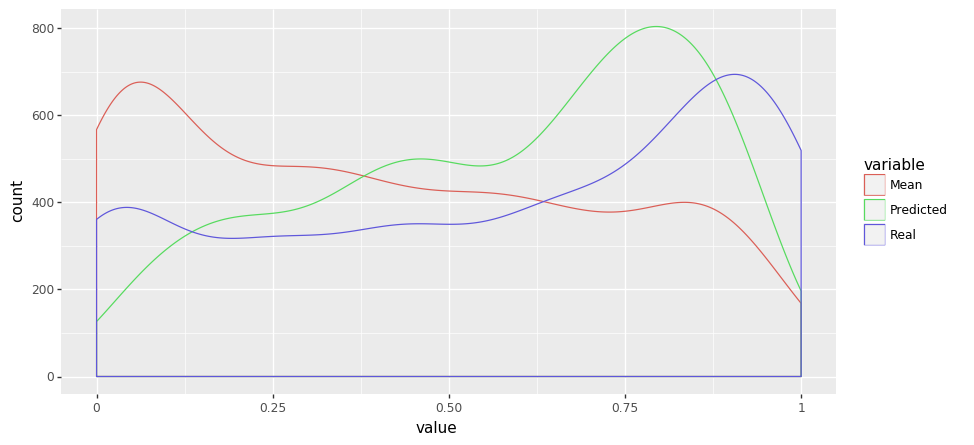

<ggplot: (2978336084637)>

In [212]:
(
    ggplot(pd.melt(comp),aes(x='value',colour='variable',group='variable'))
    +geom_density(aes(y='stat(count)'),alpha=0.4)
)

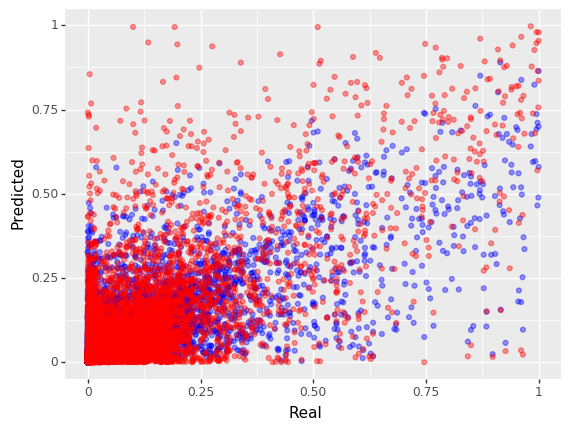

<ggplot: (2991061174836)>

In [193]:
(
    ggplot(comp,aes(x='Real'))
    +geom_point(aes(y='Predicted'),colour='blue',alpha=0.4)
    +geom_point(aes(y='Mean'),colour='red',alpha=0.4)
)

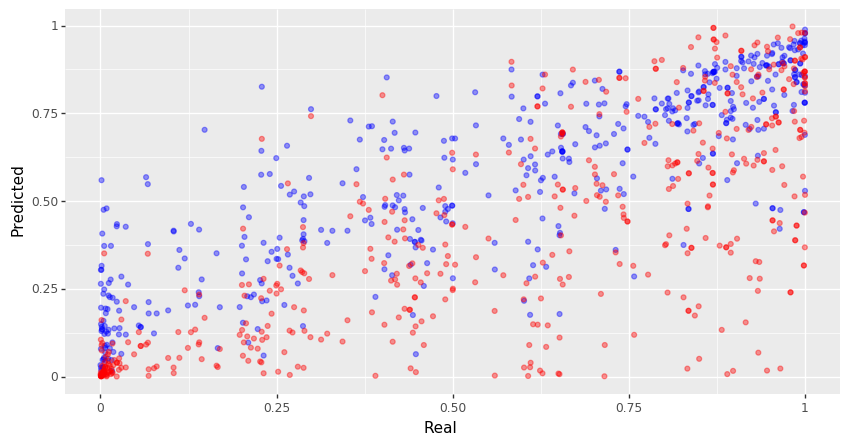

<ggplot: (2978339813590)>

In [210]:
(
    ggplot(comp,aes(x='Real'))
    +geom_point(aes(y='Predicted'),colour='blue',alpha=0.4)
    +geom_point(aes(y='Mean'),colour='red',alpha=0.4)
)

In [214]:
pd.melt(comp,id_vars='Real')

,Real,variable,value
0,0.442700,Predicted,0.448050
1,0.417560,Predicted,0.694332
2,0.210704,Predicted,0.453821
3,0.736935,Predicted,0.534778
4,0.887031,Predicted,0.896319
...,...,...,...
995,0.984255,Mean,0.877683
996,0.420631,Mean,0.292775
997,0.894592,Mean,0.884157
998,0.454629,Mean,0.268110


/homes/jhidalgo/.local/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


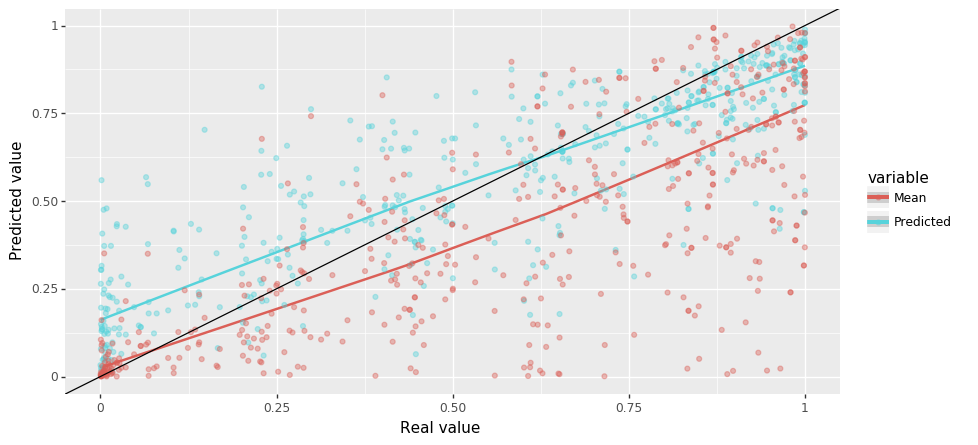

<ggplot: (2978396603155)>

In [243]:
(
    ggplot(pd.melt(comp,id_vars='Real'),aes(x='Real',y='value',colour='variable',group='variable'))
    +geom_smooth()
    +geom_point(alpha=0.4)
    +geom_abline()
    + xlab('Real value')
    + ylab('Predicted value')
)

In [122]:
i=0
while i < 1:
    diff=0.2
    real=comp[comp['Real'].between(i,i+diff)]['Real']
    predicted=comp[comp['Real'].between(i,i+diff)]['Predicted']
    mean=comp[comp['Real'].between(i,i+diff)]['Mean']
    print('Correlation for values between',"%.1f" % i,'and',"%.1f" % (i+diff),':',"%.2f" %linregress(real,predicted)[2])
    print('RMSE for values between',"%.1f" % i,'and',"%.1f" % (i+diff),':',"%.2f" %np.sqrt(mean_squared_error(real,predicted)),'\n')
    i=i+diff

Correlation for values between 0.0 and 0.2 : 0.61
RMSE for values between 0.0 and 0.2 : 0.05 

Correlation for values between 0.2 and 0.4 : 0.21
RMSE for values between 0.2 and 0.4 : 0.14 

Correlation for values between 0.4 and 0.6 : 0.22
RMSE for values between 0.4 and 0.6 : 0.25 

Correlation for values between 0.6 and 0.8 : 0.31
RMSE for values between 0.6 and 0.8 : 0.38 

Correlation for values between 0.8 and 1.0 : 0.25
RMSE for values between 0.8 and 1.0 : 0.46 



In [116]:
str(i)

'1.0'

In [ ]:
##### DELETE FROM HERE (KEPT TO SHOW)

In [385]:
data_GM

,var_chr,var_pos_s,var_pos_e,var_Ref,var_Alt,contig,start,end,gene_id,eQTL,...,regbuild_gene_end,regbuild_gene_regulatory_feature_stable_id,regbuild_gene_feature_type,regbuild_gene_activity,regbuild_snp_seq_id,regbuild_snp_start,regbuild_snp_end,regbuild_snp_regulatory_feature_stable_id,regbuild_snp_feature_type,regbuild_snp_activity
2,1,777135,777135,T,TC,1,725885,778626,ENSG00000228327,chr1_777135_T_TC,...,729421,ENSR00000000074,Open chromatin,REPRESSED,0,-1,-1,0,0,0
3,1,777135,777135,T,TC,1,725885,778626,ENSG00000228327,chr1_777135_T_TC,...,727790,ENSR00000000073,TF binding site,INACTIVE,0,-1,-1,0,0,0
4,1,777135,777135,T,TC,1,725885,778626,ENSG00000228327,chr1_777135_T_TC,...,734192,ENSR00000000076,Open chromatin,INACTIVE,0,-1,-1,0,0,0
5,1,777135,777135,T,TC,1,725885,778626,ENSG00000228327,chr1_777135_T_TC,...,730628,ENSR00000000075,Open chromatin,INACTIVE,0,-1,-1,0,0,0
6,1,777135,777135,T,TC,1,725885,778626,ENSG00000228327,chr1_777135_T_TC,...,740806,ENSR00000000078,Open chromatin,INACTIVE,0,-1,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29474,X,154356517,154356517,C,A,X,154389955,154409168,ENSG00000147403,chrX_154356517_C_A,...,154391201,ENSR00000249669,Promoter,ACTIVE,0,-1,-1,0,0,0
29475,X,154356517,154356517,C,A,X,154389955,154409168,ENSG00000147403,chrX_154356517_C_A,...,154409601,ENSR00000249672,Promoter,ACTIVE,0,-1,-1,0,0,0
29476,X,154412069,154412069,T,C,X,154411518,154421726,ENSG00000102125,chrX_154412069_T_C,...,154412401,ENSR00000344175,Promoter,ACTIVE,X,154410800,154412401,ENSR00000344175,Promoter,ACTIVE
29477,X,154405612,154405612,C,T,X,154444126,154450654,ENSG00000071859,chrX_154405612_C_T,...,154445201,ENSR00000249675,Promoter,ACTIVE,0,-1,-1,0,0,0


In [469]:
mean_eQTL

{'rmse': 0.29940569726541905, 'r_value': 0.5656788565719999}

In [485]:
mean_regressor_local(original_eQTL_data_ML,eQTL_features,target)

{'rmse': 0.19777020725842678, 'r_value': 0.6444580457617779}

In [497]:
random_forest_regressor_local(original_eQTL_data_ML.fillna(0),eQTL_features,target,random_state=random_state)

{'rmse': 0.1493412498820004,
 'r_value': 0.6684529548463866,
 'feature_importances': [('Spleen', 0.23),
  ('Whole_Blood', 0.06),
  ('Cells_Cultured_fibroblasts', 0.05),
  ('Esophagus_Mucosa', 0.05),
  ('Prostate', 0.04),
  ('Testis', 0.04),
  ('Colon_Transverse', 0.03),
  ('Esophagus_Muscularis', 0.03),
  ('Adipose_Subcutaneous', 0.02),
  ('Artery_Coronary', 0.02),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.02),
  ('Heart_Atrial_Appendage', 0.02),
  ('Heart_Left_Ventricle', 0.02),
  ('Lung', 0.02),
  ('Nerve_Tibial', 0.02),
  ('Skin_Not_Sun_Exposed_Suprapubic', 0.02),
  ('Small_Intestine_Terminal_Ileum', 0.02),
  ('Thyroid', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Adrenal_Gland', 0.01),
  ('Artery_Aorta', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Anterior_cingulate_cortex_BA24', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cerebellum', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Hypothalamus', 0.01),
  ('Brain_Putamen_basa

In [498]:
random_forest_regressor_local(ML_data, eQTL_features, target, random_state=random_state)

{'rmse': 0.04750376176665008,
 'r_value': 0.9732563614212232,
 'feature_importances': [('Whole_Blood', 0.28),
  ('Heart_Atrial_Appendage', 0.07),
  ('Adrenal_Gland', 0.05),
  ('Cells_Cultured_fibroblasts', 0.05),
  ('Spleen', 0.05),
  ('Colon_Transverse', 0.04),
  ('Artery_Coronary', 0.03),
  ('Lung', 0.03),
  ('Skin_Sun_Exposed_Lower_leg', 0.03),
  ('Adipose_Subcutaneous', 0.02),
  ('Esophagus_Mucosa', 0.02),
  ('Esophagus_Muscularis', 0.02),
  ('Muscle_Skeletal', 0.02),
  ('Nerve_Tibial', 0.02),
  ('Prostate', 0.02),
  ('Small_Intestine_Terminal_Ileum', 0.02),
  ('Testis', 0.02),
  ('Adipose_Visceral_Omentum', 0.01),
  ('Artery_Aorta', 0.01),
  ('Artery_Tibial', 0.01),
  ('Brain_Caudate_basal_ganglia', 0.01),
  ('Brain_Cortex', 0.01),
  ('Brain_Frontal_Cortex_BA9', 0.01),
  ('Brain_Nucleus_accumbens_basal_ganglia', 0.01),
  ('Brain_Substantia_nigra', 0.01),
  ('Breast_Mammary_Tissue', 0.01),
  ('Esophagus_Gastroesophageal_Junction', 0.01),
  ('Heart_Left_Ventricle', 0.01),
  ('Liver'

In [501]:
ML_data[eQTL_features]

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
2,0.000000,0.0,0.000000,0.000000,0.0,0.50537,0.0,0.000000,0.000000,0.000000,...,0.308932,0.729121,0.0,0.000000,0.0,0.181214,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.50537,0.0,0.000000,0.000000,0.000000,...,0.308932,0.729121,0.0,0.000000,0.0,0.181214,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.000000,0.0,0.50537,0.0,0.000000,0.000000,0.000000,...,0.308932,0.729121,0.0,0.000000,0.0,0.181214,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.000000,0.000000,0.0,0.50537,0.0,0.000000,0.000000,0.000000,...,0.308932,0.729121,0.0,0.000000,0.0,0.181214,0.0,0.0,0.0,0.000000
6,0.000000,0.0,0.000000,0.000000,0.0,0.50537,0.0,0.000000,0.000000,0.000000,...,0.308932,0.729121,0.0,0.000000,0.0,0.181214,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29474,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
29475,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
29476,0.762146,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.524988,0.595566,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.987990
29477,0.000000,0.0,0.221914,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [502]:
original_eQTL_data_ML[eQTL_features]

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
2,NaN,NaN,NaN,NaN,NaN,0.505370,NaN,NaN,NaN,NaN,...,0.308932,0.729121,NaN,NaN,NaN,0.181214,NaN,NaN,NaN,NaN
4,0.501137,NaN,NaN,NaN,NaN,0.237723,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.194231,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.499202,0.522539,NaN,NaN,NaN,NaN,0.181604,NaN,NaN,NaN
9,0.982033,0.970686,NaN,0.746407,NaN,0.986695,NaN,0.302696,NaN,0.307415,...,0.986261,0.973677,NaN,0.301884,0.832681,NaN,0.861533,NaN,NaN,NaN
11,0.256900,0.223422,0.179973,0.218254,NaN,0.315876,NaN,NaN,NaN,NaN,...,0.232895,0.249598,0.177435,NaN,0.179155,0.180749,0.214848,0.153066,0.152921,0.311301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4088,0.762146,NaN,NaN,NaN,NaN,NaN,NaN,0.524988,0.595566,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987990
4089,NaN,NaN,0.221914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
